# 설명

[배경]

전통적인 금융권은 소상공인 대출 시 신용점수 또는 담보물 위주의 평가를 진행합니다. 한편 한국의 핀테그 기업인 'FUNDA'는 상환기간의 매출을 예측하여 신용점수가 낮거나 담보를 가지지 못하는 우수 상점들에 금융 기회를 제공하려 합니다.

이번 대회에서 **상환 기간의 '총 매출'을 예측**하는 모델을 만들어주세요. 펀다에서는 예측된 매출을 기반으로 대출한도를 설정합니다. 모델이 정확할수록 더 낮은 금리와 더 높은 한도를 제공할 수 있게 됩니다.

[기초설명]

한국의 약 2000개 상점의 신용카드 거래 내역이 제공됨.

card_id를 기준으로 샘플링 되었으며,
amount의 단위는 KRW가 아니다.

테스트 파일에서 **각 상점의 마지막 매출 발생일 다음날부터 100일후까지의 매출의 총합을 예측**해야합니다.

# columns 설명

store_id
* 각 파일에서의 **상점 고유 번호** (**해당기한 내 개업 혹은 폐업한 상점도 있음**)

date 
* 거래일자

time
* 거래시간

card_id
* 카드 번호의 hash값

amount

* 매출 금액, *음수인 경우 취소 거래*

installments
* 할부 개월 수. 일시불은 빈 문자열

days_of_week

* 요일, 월요일이 0, 일요일은 6

holiday
* 1이면 공휴일, 0이면 공휴일 아님


# import library and data

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle study/[2]store/test.csv")

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle study/[2]store/submission.csv")
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle study/[2]store/train.csv")

In [ ]:
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


In [ ]:
test.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-08-01,00:28:15,bf33518373,125,NaN,0,0
1,0,2016-08-01,01:09:58,7a19a3a92f,90,NaN,0,0
2,0,2016-08-01,01:47:24,6f9fd7e241,150,NaN,0,0
3,0,2016-08-01,17:54:43,8bcf1d61b2,362,NaN,0,0
4,0,2016-08-01,18:48:53,6a722ce674,125,NaN,0,0


In [ ]:
submission.head()

,store_id,total_sales
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
len(train.store_id.unique())

1775

In [ ]:
len(test.store_id.unique()) # 약 1975개의 store 주어짐


200

# Pre-processing

##Date 형태 변환 & Time drop

In [ ]:
df_copy = test.copy()

In [ ]:
print(df_copy.date)
df_copy.date = pd.to_datetime(df_copy.date)
print('-------------------')
print(df_copy.date)

0         2016-08-01
1         2016-08-01
2         2016-08-01
3         2016-08-01
4         2016-08-01
             ...    
473387    2018-03-30
473388    2018-03-30
473389    2018-03-30
473390    2018-03-30
473391    2018-03-31
Name: date, Length: 473392, dtype: object
-------------------
0        2016-08-01
1        2016-08-01
2        2016-08-01
3        2016-08-01
4        2016-08-01
            ...    
473387   2018-03-30
473388   2018-03-30
473389   2018-03-30
473390   2018-03-30
473391   2018-03-31
Name: date, Length: 473392, dtype: datetime64[ns]


In [ ]:
df_copy.date = pd.to_datetime(df_copy.date.astype(str) + " " + df_copy.time, format='%Y-%m-%d %H:%M:%S')
df_copy = df_copy.drop('time',axis=1)
df_copy.head()

,store_id,date,card_id,amount,installments,days_of_week,holyday
0,0,2016-08-01 00:28:15,bf33518373,125,NaN,0,0
1,0,2016-08-01 01:09:58,7a19a3a92f,90,NaN,0,0
2,0,2016-08-01 01:47:24,6f9fd7e241,150,NaN,0,0
3,0,2016-08-01 17:54:43,8bcf1d61b2,362,NaN,0,0
4,0,2016-08-01 18:48:53,6a722ce674,125,NaN,0,0


## negative amount

어떤 가게들은 취소거래(return)때문에 하루 매출 자체가 음수가 되는 경우가 있다.

In [ ]:
df_neg_amount = test.copy()
df_neg_amount = df_neg_amount.groupby(['store_id','date'])['amount'].sum()
df_neg_amount = pd.DataFrame(df_neg_amount)
(df_neg_amount['amount']< 0).sum()

49

## Prediction Interval
왜 예측 구간을 사용해야 하는 지

**Prediction Interval**

What is a Prediction Interval?

예측 구간은 **회귀분석의 예측에 사용**되는  **일종의 신뢰구간**의 한 종류이다.
(A prediction interval is a type of confidence interval (CI) used with predictions in regression analysis;)

기존 모델을 기반으로, **새로운 관측치 값을 예측하는 값의 범위**이다.(it is a range of values that predicts the value of a new observation, based on your existing model.
)

예측 구간과 신뢰구간은 같은 것이 아니다.(Prediction and confidence intervals are often confused with each other. However, they are not quite the same thing.)

신뢰구간은 모집단의 파라미터와 관련된 값의 범위 EX)모집단의 평균

예측 간격은 미래값이 떨어질 것으로 예상되는 지점

* A confidence interval is a range of values associated with a population parameter. For example, the mean of a population.

* A prediction interval is where you expect a future value to fall.

**신뢰구간은** 불확실성의 정도를 나타내는 **신뢰수준과 항상 연관된다**.

예를 들어서, 95% 신뢰 수준에서 배터리의 평균 수명은 100~110시간이라고 할 수 있습니다. 

즉, 배터리가 100시간~110시간 범위로 떨어지는 가능성(확률)이 95%에 달합니다. 

마찬가지로, 충분한 샘플과 정확한 시간의 백분율이 있다는 가정하에,

**예측 구간은 값이 미래에 어디에 속할지 알려준다.**

예를 들어서 **95% 예측 간격 100~110시간**이면 **향후 생산되 배터리가 95%의 시간 범위에 속하게 된다**. **배터리가 이 간격에 속하지 않을 가능성은 5%이다.**


**The Uncertainties with Intervals**
Just like most things in statistics, it doesn’t mean that you can predict with certainty where one single value will fall.

Confidence intervals are always associated with a confidence level, representing a degree of uncertainty (data is random, and so results from statistical analysis are never 100% certain).
For example, you might say that the mean life of a battery (at a 95% confidence level) is 100 to 110 hours. This tells you that a battery will fall into the range of 100 to 110 hours 95% of the time.

Similarly, the prediction interval tells you where a value will fall in the future, given enough samples, a certain percentage of the time. A 95% prediction interval of 100 to 110 hours for the mean life of a battery tells you that future batteries produced will fall into that range 95% of the time. There is a 5% chance that a battery will not fall into this interval.

신뢰구간 사용 

* 경제 지표

그러나 정확한 결과를 얻으려면 신뢰수준 대신 예측 구간을 사용해야 한다.

이 신뢰구간를 사용하여 예측 간격을 만들면 간격이 훨씬 좁아집니다.
예를 들어 예측 간격은 동일한 신뢰 수준에서 $2,500에서 7,500 사이일 수 있습니다.


신뢰 구간을 사용하면 간격에 오류가 더 많이 발생할 가능성이 높습니다. 즉, 값이 예상보다 자주 해당 간격을 벗어나게 됩니다.

**When to Use It**
It’s very common to use the confidence interval in place of the prediction interval, especially in econometrics. However, you should use a prediction interval instead of a confidence level if you want accurate results. Let’s say you calculate a confidence interval for the mean daily expenditure of your business and find it’s between $5,000 and $6,000. That tells you where the mean probably lies. If you use that CI to make a prediction interval, you will have a much narrower interval. For example, the prediction interval might be $2,500 to $7,500 at the same confidence level. If you do use the confidence interval, it’s highly likely that interval will have more error, meaning that values will fall outside that interval more often than you predict.

Be careful when interpreting prediction intervals and coefficients if you transform the response variable: the slope will mean something different and any predictions and confidence/prediction intervals will be for the transformed response (Morgan, 2014).

# prediction interval과 prediction의 관계

**prediction interval과 prediction의 관계**

??

# amount 음수값 제거

variance가 크면 prediction interval이 커지게 되어 prediction에 악영향을 줄 수 있다

따라서,

음수들을 제거한다.

음수 제거 방법

카드 아이디를 이용하여 어떤 카드의 negative transaction의 거래 시간보다 먼저 이루어지면서 가장 최근 transaction 중
1. 절댓값이 같은 양수 가격의 transaction을 제거
2. 같은 값이 존재하지 않으면 절대값이 더 큰 양수 transaction 가격에서 음수transaction의 가격만큼 빼는 방법으로 음수들을 제거
3. 카드 아이디가 1,2에 해당하지 않을 경우,
해당 환불의 실제 구매는 데이터의 시작 시간보다 과거이므로 데이터에서 제외



In [ ]:
import datetime as dt

In [ ]:
df_copy

,store_id,date,card_id,amount,installments,days_of_week,holyday
0,0,2016-08-01 00:28:15,bf33518373,125,NaN,0,0
1,0,2016-08-01 01:09:58,7a19a3a92f,90,NaN,0,0
2,0,2016-08-01 01:47:24,6f9fd7e241,150,NaN,0,0
3,0,2016-08-01 17:54:43,8bcf1d61b2,362,NaN,0,0
4,0,2016-08-01 18:48:53,6a722ce674,125,NaN,0,0
...,...,...,...,...,...,...,...
473387,199,2018-03-30 14:17:59,300d7bc922,65,NaN,4,0
473388,199,2018-03-30 19:01:54,3ab757718b,65,NaN,4,0
473389,199,2018-03-30 20:08:03,2d8e9e421c,65,NaN,4,0
473390,199,2018-03-30 20:11:58,22daeb334e,200,NaN,4,0


In [ ]:
df_copy.to_records()

rec.array([(     0,   0, '2016-08-01T00:28:15.000000000', 'bf33518373', 125, nan, 0, 0),
           (     1,   0, '2016-08-01T01:09:58.000000000', '7a19a3a92f',  90, nan, 0, 0),
           (     2,   0, '2016-08-01T01:47:24.000000000', '6f9fd7e241', 150, nan, 0, 0),
           ...,
           (473389, 199, '2018-03-30T20:08:03.000000000', '2d8e9e421c',  65, nan, 4, 0),
           (473390, 199, '2018-03-30T20:11:58.000000000', '22daeb334e', 200, nan, 4, 0),
           (473391, 199, '2018-03-31T11:41:18.000000000', '2e698f3302', 500, nan, 5, 0)],
          dtype=[('index', '<i8'), ('store_id', '<i8'), ('date', '<M8[ns]'), ('card_id', 'O'), ('amount', '<i8'), ('installments', '<f8'), ('days_of_week', '<i8'), ('holyday', '<i8')])

In [ ]:
def reduce_noise_by_removing_neg_vals(df_copy):
  df_pos = df_copy[df_copy.amount > 0] # 구매
  df_neg = df_copy[df_copy.amount < 0] # 환불

  start = dt.datetime.now()

  array_neg = df_neg.to_records()# array가 된다.
  for neg_instance in array_neg:

    store_i = neg_instance[1]
    date_i = neg_instance[2]
    card_i = neg_instance[4]
    amt_i = neg_instance[5]

    row_i = df_pos[df_pos.store_id == store_i]# 가게찾기
    row_i = row_i[row_i.card_id == card_i]#카드 찾기
    row_i = row_i[row_i.amount >= abs(amt_i)]#금액 찾기
    row_i = row_i[row_i.date < date_i]# 날짜 찾기
    
    if len(row_i[row_i.amount == abs(amt_i)]) > 0:
      row_i = row_i[row_i.amount == abs(amt_i)]
      matched_row = row_i[row_i.date == max(row_i.date)]# 가장 최근
      df_pos = df_pos.loc[~df_pos.index.isin(matched_row.index), :]

    elif len(row_i[row_i.amount > abs(amt_i)]) >0:
      matched_row = row_i[row_i.date == max(row_i.date)]
      df_pos.loc[matched_row.index,"amount"] = matched_row.amount + amt_i # amt_i가 음수
      # df_pos.loc[matched_row.index,"amount"] +=amt_i # 이것도 가능할듯
      # else:
        ### pass ###
        # 이 경우, 이 환불건의 구매는 데이터 시작 전에 이루어졌다고 판단하여 그냥 없는 것으로 판단

  end = dt.datetime.now()
  time_took = (end-start).seconds/60
  print("time_took : ",round(time_took,2))

  return df_pos
df_pos = reduce_noise_by_removing_neg_vals(df_copy)

time_took :  12.55


# Augmented Dickey Fuller test

staionary : 정상성

vs

Non-stationary : 비정상성

**정상성 시계열 데이터 확인 방법**

stationary 한 시계열 데이터인지 아닌지 확인하는 방법들

1. 눈으로 보기

plotting 해서 시간에 따라 변하는지 본다.

2. 간단한 평균 내보기
 대략 반으로 쪼개서 앞의 평균과 뒤의 평균이 얼마나 다른지 본다.

 3. statistical test : 통계적 검정 시행

 ADF 검정

 검정통계량(ADF statistics)이 Critical Value 보다 작으면 stationary 한 시계열 데이터
 
 혹은,

p-value가 설정한 신뢰수준 값(eg.0.05) 보다 작은지 큰지 확인하면 된다.

작으면 stationary 한 시계열 데이터

---

참조
https://dodonam.tistory.com/235


https://byeongkijeong.github.io/ARIMA-with-Python/

https://ichi.pro/ko/gigye-hagseub-eul-wihan-sigyeyeol-bunseog-108215694852613

시계열 acf,pacf

https://direction-f.tistory.com/65

 qq plot

 https://blog.naver.com/PostView.nhn?blogId=sw4r&logNo=221026102874&parentCategoryNo=&categoryNo=117&viewDate=&isShowPopularPosts=true&from=search

ADF 검정, Augmented Dicky-Fuller Test



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

검정값이 critical value보다 작고

p-value가 0.05보다 작으므로

통계적으로 볼때, stationary한 시계열 데이터라고 판단할 수 있다!

In [ ]:
def adf_test(y):
    # perform Augmented Dickey Fuller test
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    # print(dfoutput)
    # print('---------------------------')
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value

    print(dfoutput)

# adf_test(df_pos.amount)

In [ ]:
# layout = (3, 2)
# layout
# acf_ax = plt.subplot2grid(layout, (1, 0))
# acf_ax

판매금액과 로그를 씌운 판매금액이 완전히는 아니지만 어느정도는 정규분포에 비슷함을 QQ plot으로 확인. outlier들의 영향을 줄이기 위해 로그를 씌운 판매금액을 종속변수로 사용하기로 결정.


No handles with labels found to put in legend.


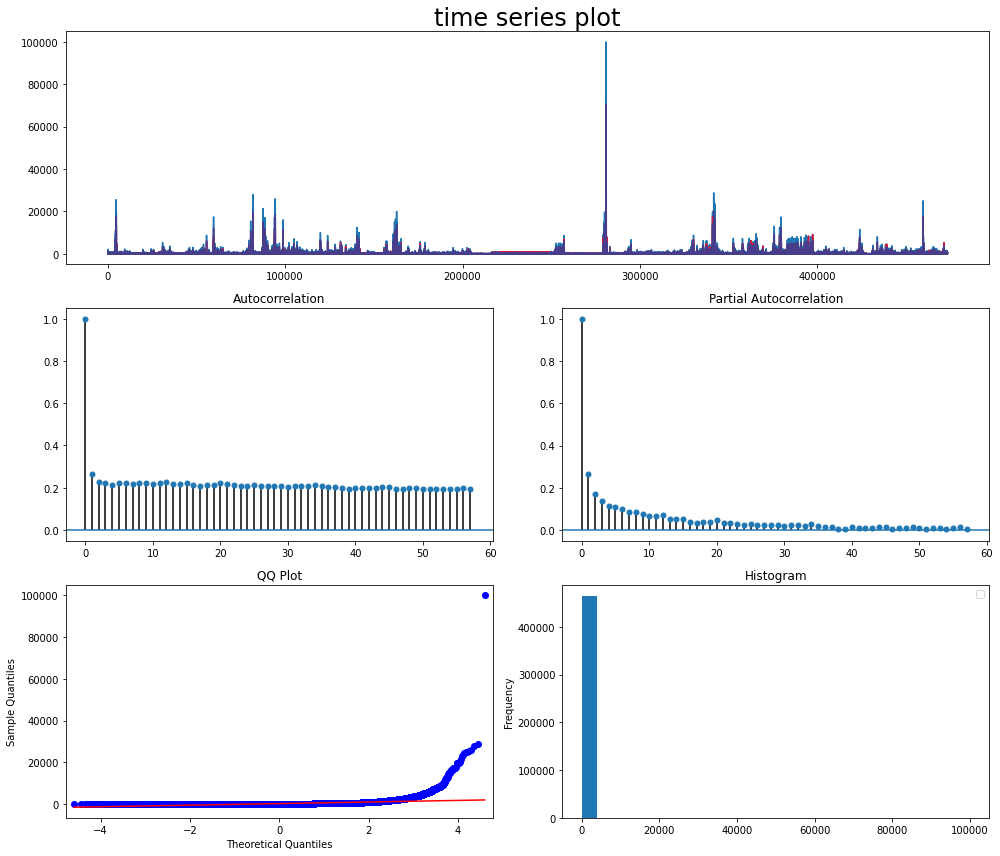

NameError: ignored

In [ ]:
def ts_diagnostics(y, lags=None, title='', filename=''):
    '''
    Calculate acf, pacf, qq plot and Augmented Dickey Fuller test for a given time series
    '''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    # weekly moving averages (5 day window because of workdays)
    rolling_mean = pd.Series.rolling(y, window=2).mean() # 2일치 평균
    rolling_std = pd.Series.rolling(y, window=2).std() # 2일치 분산

    # 바탕 그리기(축)
    fig = plt.figure(figsize=(14, 12))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))

    # time series plot
    y.plot(ax=ts_ax)
    rolling_mean.plot(ax=ts_ax, color='crimson')
    rolling_std.plot(ax=ts_ax, color='darkslateblue')
    plt.legend(loc='best')
    ts_ax.set_title('time series plot', fontsize=24)

    # # acf and pacf
    plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5) # plot_acf가 autocorrelation의 그림을 그려준다.
    # x축은 lag이고 y축은 correlation이다.
    # 0일 때는 당연히 1이다. 왜냐하면 자기 자신과의 관계기 때문에 당연히 1이 나온다.
    # x축 부분을 보면 파란색 범위가 보인다. 저 범위를 벗어나 있으면 Autocorrelation이 있다고 판단하고(use_vlines=True) 
    # 내부에 있다면 Autocorrelation이 없다고 판단한다)

    plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

    # # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')

    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plt.tight_layout()
    plt.show()

    # perform Augmented Dickey Fuller test
    adf_test(y)
    # print("-------------------------------")
    # print('Results of Dickey-Fuller test:')
    # dftest = adfuller(y, autolag='AIC')
    # dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    # for key, value in dftest[4].items():
    #     dfoutput['Critical Value (%s)' % key] = value
    # print(dfoutput)
    return
ts_diagnostics(df_pos.amount)

# store_list

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
import math
import scipy.stats as st
import itertools

In [ ]:
df_pos.head()

,store_id,date,card_id,amount,installments,days_of_week,holyday
0,0,2016-08-01 00:28:15,bf33518373,125,NaN,0,0
1,0,2016-08-01 01:09:58,7a19a3a92f,90,NaN,0,0
2,0,2016-08-01 01:47:24,6f9fd7e241,150,NaN,0,0
3,0,2016-08-01 17:54:43,8bcf1d61b2,362,NaN,0,0
4,0,2016-08-01 18:48:53,6a722ce674,125,NaN,0,0


In [ ]:
df = df_pos.copy()

test_groupby_date_store = df.groupby(['date','store_id'])['amount','holyday'].sum()
test_groupby_date_store = test_groupby_date_store.reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test_groupby_date_store.head()

,date,store_id,amount,holyday
0,2016-08-01 00:02:42,96,90,0
1,2016-08-01 00:12:43,125,260,0
2,2016-08-01 00:20:28,88,50,0
3,2016-08-01 00:22:01,88,30,0
4,2016-08-01 00:24:27,60,122,0


In [ ]:
test_groupby_date_store = test_groupby_date_store.set_index('date')

In [ ]:
test_groupby_date_store.head()

,store_id,amount,holyday
date,,,
2016-08-01 00:02:42,96,90,0
2016-08-01 00:12:43,125,260,0
2016-08-01 00:20:28,88,50,0
2016-08-01 00:22:01,88,30,0
2016-08-01 00:24:27,60,122,0


store_list

In [ ]:
store_list = test_groupby_date_store.store_id.unique()
store_list.sort()
store_list

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

# 데이터 기간

스토어마다 데이터 기간이 다르다.

따라서 스토어마다 다른 리샘플링 기간을 줄 필요가 있다.

요일에 따른 seasonality가 있음으로 최소한 1주일 단위로 묶어서 seasonality를 없앨 필요가 있다.

매년 있는 seasonality 있으므로 365.25로 잘 나눠 떨어지는 숫자로 정할 필요가 있다.

365.25/7=52.18

365.25/14=26.09

365.25/21=17.39

365.25/28=13.04

잘 나눠떨어지는 7,14,28일 단위로 downsamplig 하여 최소 샘플의 숫자를 넘지 못하는 경우, 점점 더 적은 기간으로 downsampling한다.

리샘플링을 할 때 나누어 떨어지지 않으면 마지막 bin 안에 들어있는 샘플의 개수가 다른 bin의 개수보다 적다.

하지만! 각 bin에 해당하는 기간의 길이가 같아야하고,

최근의 데이터가 과거의 데이터보다 중요하기 때문에 (28,14로) 나누어 떨어지지 않을 경우, 앞의 남는 샘플들을 제거




In [ ]:
data_len = pd.DataFrame()
for i, store_i in enumerate(store_list[:20]):
  # test_df는 store_df와 같다.
  store_df = test_groupby_date_store[test_groupby_date_store.store_id == store_i]
  store_of_daily = store_df.loc[:,('amount','holyday')].resample('D').sum() # date를 하루 단위로 만듬
  # print(store_df.store_id.unique())
  data_len.loc[i,'store_id'] = store_df.store_id.unique()
  data_len.loc[i,'start_day'] = min(store_of_daily.index)
  data_len.loc[i,'end_day'] = max(store_of_daily.index)
  # print(data_len)

In [ ]:
data_len

,store_id,start_day,end_day
0,0.0,2016-08-01,2018-03-31
1,1.0,2016-08-03,2018-03-30
2,2.0,2016-08-01,2018-03-30
3,3.0,2016-08-01,2018-03-31
4,4.0,2016-08-01,2018-03-31
5,5.0,2016-08-03,2018-03-31
6,6.0,2016-08-01,2018-03-31
7,7.0,2017-02-25,2018-03-31
8,8.0,2017-09-13,2018-03-31
9,9.0,2017-10-23,2018-03-31


# 최적의 파라미터 찾기 & AIRMA 함수 

In [ ]:
import itertools

## 초기값(parameters)

최소의 샘플 숫자는 4, 5, 6, 8 중 6의 결과가 가장 좋아 6으로 결정.

---

PACF (편자기상관함수 http://bit.ly/2OeRail)

를 통해 AR(0), AR(1), AR(2)를 확인. 

하지만 AIC를 통해 ARIMA모델에 사용될 pqr 값들을 찾을 때 [0,2]의 값들을 통해 구한 pqr보다 

[0,1]사이로 찾은 pqr이 더 정확한 예측을 했기 때문에 pqr의 범위를 [0,1]로 설정 

In [ ]:
sampling_p = 28
mean_period = 2 * 3 #14 * 2*3

predic_len = math.floor(100 / sampling_p)
print(predic_len)

expected_return_pct_lending = 0.13 * (100 + 16 + 6.8) / 365
expected_loss_pct_lending = 1.00
optimal_prob = expected_loss_pct_lending / (expected_loss_pct_lending + expected_return_pct_lending)
optimal_z_score = st.norm.ppf(optimal_prob) # p(x > z ) = 0.0419
print(optimal_prob)
print("z_score : ",optimal_z_score)

# 초기값, 기본값 설정
min_period = 6

max_pdq = 2
p = d = q = range(0,max_pdq) # (0,1)
pdq = list(itertools.product(p, d, q)) # p, d, q조합

pdqs = dict()

output_file_name_fmt = '../1st_data/py_4arima_pos_sep_{optimal_p}-{sampling_period}_no_sales_prob&no mean{mean_period}&min_period {min_period}_pdq{max_pdq}.csv'
output_file_name = output_file_name_fmt.format(optimal_p=round(optimal_prob, 4),
                                               sampling_period=sampling_p,
                                               mean_period=mean_period,
                                               min_period=min_period,
                                               max_pdq=max_pdq)

submission_copy = submission.copy()

3
0.9580957780787686
z_score :  1.7290036387221377


## get_optimal_params

- SARIMAX에 대한 설명 : https://sosoeasy.tistory.com/397

In [ ]:
def get_optimal_params(y):
    # Define the p, d and q parameters to take any value between 0 and 1

    param_dict = {}
    for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            )
            results = mod.fit()
            # print(results.summary())

            # model = ARIMA(y, order=param)
            # results_ARIMA = model.fit(disp=-1)
            # results_ARIMA.summary()
            
            param_dict[results.aic] = param # ARIMA 모델에 사용되는 pdq값을 찹을 때는 overfitting을 방지하기 위해 AIC값을 이용해서 찾는다.(parsimony?)
            # print(param_dict)
        except:
            continue

    min_aic = min(param_dict.keys())
    optimal_params = param_dict[min_aic]
    return optimal_params

## ARIMA

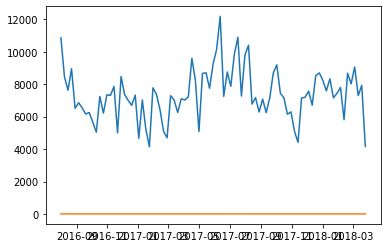

In [ ]:
test_df = test_groupby_date_store[test_groupby_date_store.store_id == 0]
test_df_daily = test_df.resample('7D').sum() # date를 일주일 단위로 만듬

a = test_df_daily.amount
plt.plot(a)
log = np.log(a)
plt.plot(log)

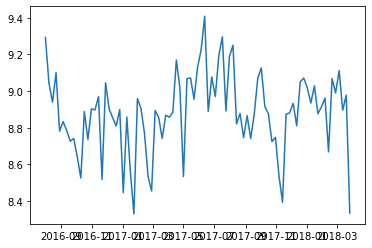

In [ ]:
log = np.log(a)
plt.plot(log)

In [ ]:
# 입력값 설명
# test_df_daily 가게별 DF
# sampling_period_days 날짜 묶음 기간 단위
# fcst_period # n일 뒤를 예측

# prediction_i = arima_main(test_df_daily,sampling_period_days = 28, fcst_period = 3)

def arima_main(input_df, sampling_period_days=28, fcst_period=3):
  # Down Sampling
  ################################################################### 
  # n일 단위로 묶음 
  ### 나머지 부분을 버리는 이유? 각 bin에 해당하는 기간의 길이가 같아야하고,
  #최근의 데이터가 과거의 데이터보다 중요하기 때문에 (28,14로) 나누어 떨어지지 않을 경우, 앞의 남는 샘플들을 제거###

  input_df = input_df[len(input_df) % sampling_period_days:].resample(str(sampling_period_days)+'D').sum()

   ######################################################################
  # 판매를 하지 않을 확률
  # null/무한대인 값들이 몇개인지 세어 몇 퍼센트의 샘플이 null/무한대인지 계산 후 최종 prediction에서 (1 - probability of no sales) 값으로 예측값을 곱하여 매출 예상에서 판매가 없을 확률만큼 discount함

  prob_of_no_sales = len(input_df[(input_df.amount == 0) | (input_df.amount.isna())]) / len(input_df)

  ######################################################################
  # amount 로그를 이용하여 정규화
  # log를 씌운 후 값이 null이 되거나 무한이 되면 데이터셋에서 제거.
  ts_log = np.log(input_df.amount)
  ts_log = ts_log[~ts_log.isin([np.nan,np.inf,-np.inf])]

  # prob_of_no_sales = len(ts_log)/len(input_df) 이걸로 변형해서 해보자
  ######################################################################
  # 원하는 개수보다 작으면 다른 단위(일)로 묶기 위해 None 반환
  if len(input_df) < min_period:
    return None
  ######################################################################
  # Optimization process: 28일, 14일, 7일씩 downsampling하여 예측하면 향후 84일 (28 3) 혹은 98일 (14 7 or 7 14) 동안의 매출을 예측 가능. 
  # E(return) == 0.13 (100 + x) / 365  ### 이 식이 도출된 이유? ###
  # 위의 E(return)안의 x값을 늘려 optimal p를 조절하는 방식으로 예측에서 빠진 기간동안의 매출을 채우기로 결정. 
  # 28일씩 리샘플링한 경우는 (84일 예측) x==22.8, 
  # 14일씩 리샘플링한 경우는 (98일 예측) x == 30 (30 이상은 test 해보지 않음)으로 했을 경우 좋은 결과가 나왔음 (Score == 49.42492). 
  if sampling_period_days >= 28:
    expected_return_pct_lending = 0.13 * (100 + 16 + 6.8) / 365 
  elif sampling_period_days >=14:
    expected_return_pct_lending = 0.13 * (100 + 16 + 14) / 365
  else:
    expected_return_pct_lending = 0.13 * (100 + 16 + 6.8) / 365
  # E(loss) == 1 
  expected_loss_pct_lending = 1.
  
  optimal_prob = expected_loss_pct_lending / (expected_loss_pct_lending + expected_return_pct_lending)
  optimal_z_score = st.norm.ppf(optimal_prob) #정규확률분포의 분위수(z_score)
###################################################################################
  optimal_params = get_optimal_params(ts_log) #최적의 파라미터
  pdqs[store_i] = optimal_params

  model = ARIMA(ts_log,order=optimal_params)
  result_ARIMA = model.fit(disp = -1)
  # result_ARIMA.summary()
  fcst = result_ARIMA.forecast(fcst_period)# 84 / 98일 후를 예측 ->100일 후를 예측
  fcst_means = fcst[0]
  fcst_stds = fcst[1]

  #Z score와 STD를 사용하여 확률적으로 점수계산공식에 가장 이상적인 예측값을 계산
  fcst_i = fcst_means - (fcst_stds * optimal_z_score)
  fcst_i = sum(map(lambda x: np.exp(x) if np.exp(x) > 0 else 0, fcst_i)) # #map(변환 함수, 순회 가능한 데이터)

  # 매출 예상에서 판매가 없을 확률만큼 discount함 (line 301).
  prediction_i = fcst_i * (1 - prob_of_no_sales)
  return prediction_i

# 함수 실행

In [ ]:
submission_copy = submission.copy()

for store_i in (store_list[:50]):
  # test_df는 store_df와 같다.
  test_df = test_groupby_date_store[test_groupby_date_store.store_id == store_i]
  # print(test_df)
  test_df_daily = test_df.resample('D').sum() # date를 하루 단위로 만듬

  prediction_i = arima_main(test_df_daily,sampling_period_days = 28, fcst_period = 3) # 28 * 3 = 84
  if prediction_i == None:
    prediction_i =  arima_main(test_df_daily,sampling_period_days = 14, fcst_period = 7) # 14 * 7 = 98
  if prediction_i == None:
    prediction_i =  arima_main(test_df_daily,sampling_period_days = 7, fcst_period = 12) # 7 * 12 = 84

  if prediction_i is None:
        test_df = test_df_daily[len(test_df_daily) % 14:].resample('14D').sum()

        prob_of_no_sales = len(test_df[(test_df.amount == 0) | (test_df.amount.isna())]) / len(test_df)
        ts_log = ts_log[~ts_log.isin([np.nan, np.inf, -np.inf])]
        ts_log_wkly = np.log(test_df.amount)

        estimated_amt = np.exp(ts_log_wkly.mean() - ts_log_wkly.std() * optimal_z_score) * (1 - prob_of_no_sales)
        prediction_i = estimated_amt * mean_period

  submission_copy.loc[submission_copy.store_id == store_i,'total_sales'] = prediction_i

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[10.06592063 10.04160392 10.02013551]
[9.04180823 9.01755917 8.99331011]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[8.77385376 8.77942263 8.7849915 ]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[9.09602069 9.10112145 9.1062222 ]
[8.29518298 8.26977953 8.24437608]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[8.24694125 8.11426389 8.02855456]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[10.00959558  9.90472955  9.8246252 ]


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[6.41016559 6.43904793 6.46793027]
[7.74621885 7.39102746 7.09005866]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[7.72033541 7.70052652 7.68071763 7.66090874 7.64109984 7.62129095
 7.60148206]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[8.61536837 8.55065202 8.54719059]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[7.99641983 7.98856706 7.98071429 7.97286151 7.96500874 7.95715597
 7.9493032 ]
[6.67646422 6.65830714 6.64015007]
[10.24348914 10.12560044 10.03544775]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[8.59059433 8.72768572 8.48592391]
[9.31521357 9.25870178 9.22464676]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[8.38557605 8.34599238 8.13118626]
[7.61544147 7.63283034 7.65021921]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmode

[8.62319712 8.65742758 8.69165805]
[8.17829959 8.0023816  7.8793891 ]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[9.31338761 9.32206988 9.33075215]
[7.20758633 6.81856359 6.50654289]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[9.52807717 9.54378439 9.55949161]
[10.54953789  9.97226285  9.62664357]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[8.08663659 8.041446   7.99625542]
[4.74784094 3.24514412 2.01520441]


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/di

[8.54457239 8.60169828 8.48188813]
[8.93590887 8.43289824 8.00109707 7.60615663 7.23477222 6.8801204
 6.53814771]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it

[5.10166631 5.12903812 5.15640994]
[8.49435295 8.39588925 8.4319684 ]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[9.23783769 9.22032439 9.20281108]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[9.96645481 9.93996588 9.91486711]
[6.79166302 6.069584   5.46526665 4.92190723 4.41750328 3.94077061
 3.48500588]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible startin

[10.38142916 10.36978133 10.35813351]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[11.23892905 11.23823842 11.23754778]
[7.54317095 7.36808657 7.01897079]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[6.56712743 5.71205352 5.62532307]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[9.38870979 9.38160567 9.37450156]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[11.45007364 11.44673724 11.44340085]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[9.41500424 9.42585489 9.43670555]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[10.78801898 10.78849587 10.78897277]
[8.96615642 8.60566752 8.3247928 ]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[9.85180681 9.80176897 9.7081465 ]
[10.31150881 10.34515087 10.37879293]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[7.29019617 7.26289338 7.2355906 ]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[8.95023461 8.92608817 8.90194173]
[9.15113262 9.19592543 9.24071825]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[4.81002884 4.72372278 4.63741673 4.55111067 4.46480461 4.37849856
 4.2921925 ]
[7.91507392 7.78993397 7.59999326]
[8.36390453 7.97654106 7.66296968]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
submission_copy.to_csv('/content/drive/MyDrive/Colab Notebooks/kaggle study/[2]store/output_file.csv', index=False)